# REN Data Analysis: User sessions and documents submitted

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Read csv and parse dates columns to datetime objects

In [2]:
df = pd.read_csv('REN Documentos 201704.csv', encoding='utf-8')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %H:%M')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M')

In [3]:
print(df.shape)
print(df.dtypes)

(68563, 5)
DocumentID                 int64
Timestamp         datetime64[ns]
Username                  object
Classification            object
Date              datetime64[ns]
dtype: object


#### Get usernames and analyze data per user

In [4]:
usernames = df['Username'].unique().tolist()
USER_SESSION_TTL = 30

print('Num of users: ', len(usernames))

Num of users:  3459


In [5]:
user_sessions = {}
all_docs_per_session = []
all_users_sessions_length = []

for user in usernames:        
    user_data = df[df['Username'] == user].sort_values(by=['Timestamp']) 
    session_buckets = []
    prev_timestamp = None

    for index, doc in user_data.iterrows():
        if prev_timestamp is None:
            prev_timestamp = doc['Timestamp']
            session_buckets.append([doc])
        else:
            difference = doc['Timestamp'] - prev_timestamp
            difference_in_min = int(divmod(difference.total_seconds(), 60)[0])

            if difference_in_min > USER_SESSION_TTL:
                # Add new session bucket
                session_buckets.append([doc])
            else:
                # Add doc to the last session bucket
                session_buckets[-1].append(doc)

            prev_timestamp = doc['Timestamp']
    
    user_docs_per_session = []
    user_sessions_length = []
    for session in session_buckets:
        user_docs_per_session.append(len(session))
        
        # Calculate session_length_in_min only if more than one document was submitted
        if len(session) > 1:
            first_doc, last_doc = session[0], session[-1]
            difference = last_doc['Timestamp'] - first_doc['Timestamp']
            session_length_in_min = int(divmod(difference.total_seconds(), 60)[0])

            user_sessions_length.append(session_length_in_min)
 
    all_docs_per_session += user_docs_per_session
    all_users_sessions_length += user_sessions_length

## Visualization and data analysis

### Analysis of docs submitted per session

In [6]:
series = pd.Series(all_docs_per_session)
series.describe()

count    6012.000000
mean       11.404358
std        36.026857
min         1.000000
25%         2.000000
50%         5.000000
75%        12.000000
max      1643.000000
dtype: float64

- There is a total of 6012 sessions
- With a mean of 11.4 documents submitted per session
- We can tell something is wrong in the data, the max number does not make sense

In [7]:
np.percentile(all_docs_per_session, [50, 95, 99])

array([ 5., 38., 85.])

The 99 percentile tell us that 99% of the values are less than 85, therefore the max value of 1643 is an outlier

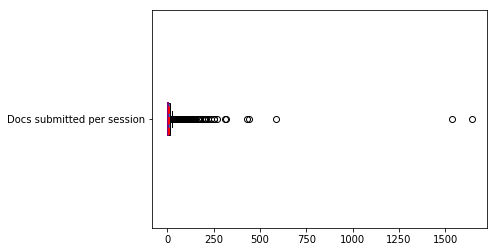

In [8]:
fig, ax = plt.subplots()
ax.boxplot((all_docs_per_session, ), vert=False,showmeans=True, meanline=True,
           labels=('Docs submitted per session', ), patch_artist=True,
           medianprops={'linewidth': 2, 'color': 'purple'},
           meanprops={'linewidth': 2, 'color': 'red'})
plt.show()

With the box plot we can observe the outliers in the data

#### Filtering data to remove outliers

In [9]:
# Filtering values less or equal than the 99 percentile
filtered_data = list(filter(lambda x: x<=85, all_docs_per_session))
np.percentile(filtered_data, [50, 75, 95, 99])

array([ 5., 12., 35., 62.])

In [10]:
series = pd.Series(filtered_data)
series.describe()

count    5953.000000
mean        9.398287
std        12.336829
min         1.000000
25%         2.000000
50%         5.000000
75%        12.000000
max        85.000000
dtype: float64

- After filtering there is a total of 5953 sessions
- With a mean of 9.4 documents submitted per session
- Now the max number is of 85 docs per session

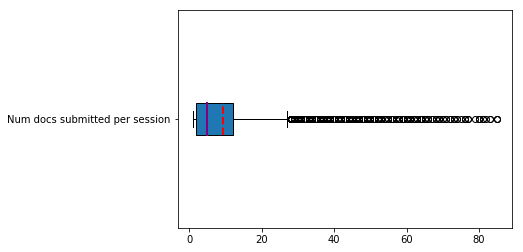

In [11]:
fig, ax = plt.subplots()
ax.boxplot((filtered_data, ), vert=False, showmeans=True, meanline=True,
           labels=('Num docs submitted per session', ), patch_artist=True,
           medianprops={'linewidth': 2, 'color': 'purple'},
           meanprops={'linewidth': 2, 'color': 'red'})
plt.show()

- The mean is the red dashed line.
The median is the purple line.
The first quartile is the left edge of the blue rectangle.
The third quartile is the right edge of the blue rectangle.
The outliers are the dots to the right.

- We can still see outliers in the box plot, but we are not filtering it, in order to see the frequency distribution in the histogram

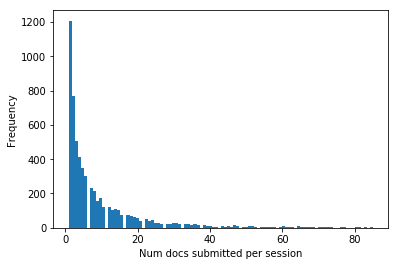

[ 1.    1.84  2.68  3.52  4.36  5.2   6.04  6.88  7.72  8.56  9.4  10.24
 11.08 11.92 12.76 13.6  14.44 15.28 16.12 16.96 17.8  18.64 19.48 20.32
 21.16 22.   22.84 23.68 24.52 25.36 26.2  27.04 27.88 28.72 29.56 30.4
 31.24 32.08 32.92 33.76 34.6  35.44 36.28 37.12 37.96 38.8  39.64 40.48
 41.32 42.16 43.   43.84 44.68 45.52 46.36 47.2  48.04 48.88 49.72 50.56
 51.4  52.24 53.08 53.92 54.76 55.6  56.44 57.28 58.12 58.96 59.8  60.64
 61.48 62.32 63.16 64.   64.84 65.68 66.52 67.36 68.2  69.04 69.88 70.72
 71.56 72.4  73.24 74.08 74.92 75.76 76.6  77.44 78.28 79.12 79.96 80.8
 81.64 82.48 83.32 84.16 85.  ]


In [12]:
hist, bin_edges = np.histogram(filtered_data, bins=100)

fig, ax = plt.subplots()
ax.hist(filtered_data, bin_edges, cumulative=False)
ax.set_xlabel('Num docs submitted per session')
ax.set_ylabel('Frequency')

plt.show()

print(bin_edges)

### Analysis and visualization of sessions duration

In [13]:
np.percentile(all_users_sessions_length, [50, 75, 95, 99])

array([ 17.  ,  37.  ,  94.  , 157.96])

In [14]:
series = pd.Series(all_users_sessions_length)
series.describe()

count    4805.000000
mean       28.206035
std        33.412910
min         0.000000
25%         6.000000
50%        17.000000
75%        37.000000
max       411.000000
dtype: float64

The mean of a user session length is of 28.20 minutes

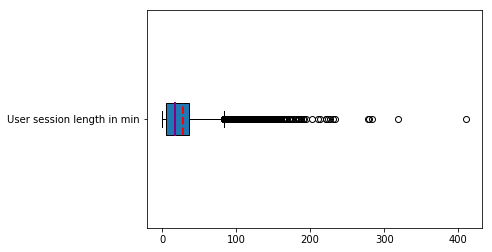

In [15]:
fig, ax = plt.subplots()
ax.boxplot((all_users_sessions_length, ), vert=False, showmeans=True, meanline=True,
           labels=('User session length in min', ), patch_artist=True,
           medianprops={'linewidth': 2, 'color': 'purple'},
           meanprops={'linewidth': 2, 'color': 'red'})
plt.show()

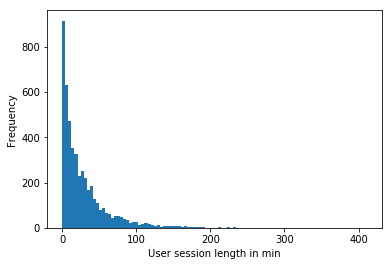

[  0.     4.11   8.22  12.33  16.44  20.55  24.66  28.77  32.88  36.99
  41.1   45.21  49.32  53.43  57.54  61.65  65.76  69.87  73.98  78.09
  82.2   86.31  90.42  94.53  98.64 102.75 106.86 110.97 115.08 119.19
 123.3  127.41 131.52 135.63 139.74 143.85 147.96 152.07 156.18 160.29
 164.4  168.51 172.62 176.73 180.84 184.95 189.06 193.17 197.28 201.39
 205.5  209.61 213.72 217.83 221.94 226.05 230.16 234.27 238.38 242.49
 246.6  250.71 254.82 258.93 263.04 267.15 271.26 275.37 279.48 283.59
 287.7  291.81 295.92 300.03 304.14 308.25 312.36 316.47 320.58 324.69
 328.8  332.91 337.02 341.13 345.24 349.35 353.46 357.57 361.68 365.79
 369.9  374.01 378.12 382.23 386.34 390.45 394.56 398.67 402.78 406.89
 411.  ]


In [16]:
hist, bin_edges = np.histogram(all_users_sessions_length, bins=100)

fig, ax = plt.subplots()
ax.hist(all_users_sessions_length, bin_edges, cumulative=False)
ax.set_xlabel('User session length in min')
ax.set_ylabel('Frequency')

plt.show()

print(bin_edges)